# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

tf.random.set_seed(12)

# Set up data

## Load data

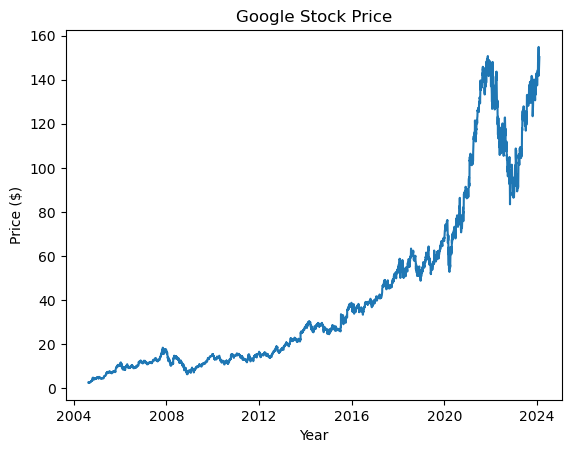

In [2]:
dataset = pd.read_csv('GOOG.csv')
dataset = dataset[['Date', 'Close']]

# Set the Date as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
plt.plot(dataset['Close'])
plt.title('Google Stock Price')
plt.ylabel('Price ($)')
plt.xlabel('Year')
plt.show()

## Scale closing price

In [3]:
closing_price = dataset['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_closing_price = scaler.fit_transform(closing_price)

dataset['Scaled_Close'] = scaled_closing_price
dataset.head()

,Close,Scaled_Close
Date,,
2004-08-20,2.697639,0.001357
2004-08-23,2.724787,0.001535
2004-08-24,2.611960,0.000795
2004-08-25,2.640104,0.000979
2004-08-26,2.687676,0.001292


## Split data (90:10)

In [4]:
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train = dataset.iloc[:train_size, :]
test = dataset.iloc[train_size:, :]

print(len(train), len(test))
print(train.head())
print(test.head())

4411 491
               Close  Scaled_Close
Date                              
2004-08-20  2.697639      0.001357
2004-08-23  2.724787      0.001535
2004-08-24  2.611960      0.000795
2004-08-25  2.640104      0.000979
2004-08-26  2.687676      0.001292
                 Close  Scaled_Close
Date                                
2022-02-28  134.891006      0.869057
2022-03-01  134.167999      0.864312
2022-03-02  134.751495      0.868142
2022-03-03  134.307999      0.865231
2022-03-04  132.121994      0.850882


## Function to create sequences of values for an Output

In [5]:
# convert dataset to create a sequence of look_back elements mapped to one output
def create_dataset(dataset, look_back=1):
  dataX = []
  dataY = []
  dates = dataset.index

  for i in range(len(dates) - look_back):
    dataX.append(dataset.loc[dates[i:(i + look_back)], 'Scaled_Close'].values)
    dataY.append(dataset.loc[dates[i + look_back], 'Scaled_Close'])
  return np.array(dataX), np.array(dataY)

## Create X and y train and test sets

In [6]:
look_back = 50
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

## Reshape data to be input into LSTM model

In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Set up model

## Specify model parameters

In [8]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Fit the model

In [9]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
137/137 - 15s - 107ms/step - loss: 0.0019
Epoch 2/50
137/137 - 7s - 53ms/step - loss: 1.8654e-04
Epoch 3/50
137/137 - 9s - 65ms/step - loss: 1.9699e-04
Epoch 4/50
137/137 - 5s - 35ms/step - loss: 1.8221e-04
Epoch 5/50
137/137 - 5s - 35ms/step - loss: 1.5824e-04
Epoch 6/50
137/137 - 5s - 33ms/step - loss: 1.5007e-04
Epoch 7/50
137/137 - 4s - 33ms/step - loss: 1.4663e-04
Epoch 8/50
137/137 - 5s - 34ms/step - loss: 1.4176e-04
Epoch 9/50
137/137 - 4s - 33ms/step - loss: 1.3663e-04
Epoch 10/50
137/137 - 4s - 32ms/step - loss: 1.3109e-04
Epoch 11/50
137/137 - 5s - 34ms/step - loss: 1.2562e-04
Epoch 12/50
137/137 - 4s - 32ms/step - loss: 1.2071e-04
Epoch 13/50
137/137 - 5s - 33ms/step - loss: 1.1625e-04
Epoch 14/50
137/137 - 4s - 33ms/step - loss: 1.1180e-04
Epoch 15/50
137/137 - 5s - 33ms/step - loss: 1.0700e-04
Epoch 16/50
137/137 - 4s - 33ms/step - loss: 1.0163e-04
Epoch 17/50
137/137 - 4s - 32ms/step - loss: 9.5678e-05
Epoch 18/50
137/137 - 5s - 35ms/step - loss: 8.9312e-05
Epo

# Evaluate model

## Predict values using model on train and test sets

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


## Reshape y sets in order to inverse scale

In [11]:
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

## Inverse transform the results and flatten the arrays

In [12]:
train_predict_inverse = scaler.inverse_transform(train_predict)
y_train_inverse = scaler.inverse_transform(y_train_reshaped)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_test_inverse = scaler.inverse_transform(y_test_reshaped)

y_train_flattened = np.array(y_train_inverse).flatten()
y_test_flattened = np.array(y_test_inverse).flatten()
train_predict_flattened = np.array(train_predict_inverse).flatten()
test_predict_flattened = np.array(test_predict_inverse).flatten()

## Calculate metrics

In [13]:
train_mse = mean_squared_error(y_train_flattened, train_predict_flattened)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_flattened, train_predict_flattened)

test_mse = mean_squared_error(y_test_flattened, test_predict_flattened)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_flattened, test_predict_flattened)

## Print metrics

In [14]:
print(f'Train MSE: {train_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Train MAE: {train_mae}')

print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

Train MSE: 0.6764568601476129
Train RMSE: 0.8224699752256084
Train MAE: 0.49883055980080754
Test MSE: 5.987569903768192
Test RMSE: 2.4469511445405265
Test MAE: 1.8200074967292907


# Visualization
## Comparison between true and predicted values on the test set

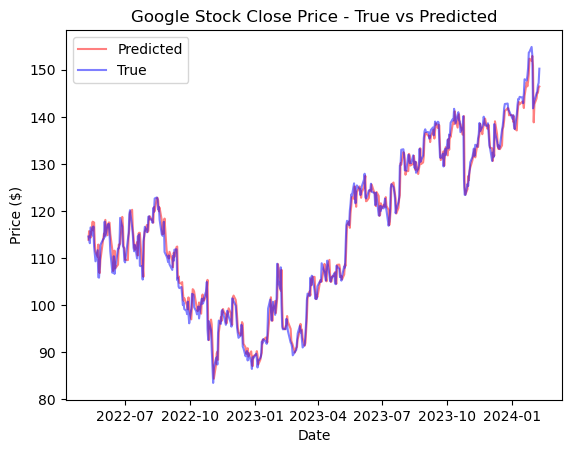

In [15]:
dates = test.index[look_back:]
plt.plot(dates, test_predict_flattened, color = "r", alpha=0.5, label = "Predicted")
plt.plot(dates, y_test_flattened, color = "b", alpha=0.5, label = "True")
plt.title('Google Stock Close Price - True vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## Comparison between true and predicted values in 2024

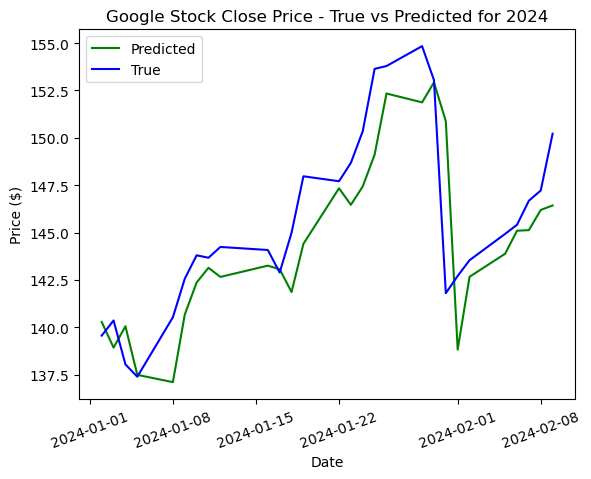

In [16]:
df_predicted = pd.DataFrame(data={'Date': dates, 'Close': test_predict_flattened})
df_predicted.set_index('Date', inplace=True)

plt.title('Google Stock Close Price - True vs Predicted for 2024')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_predicted[df_predicted.index.year >= 2024]['Close'], 'green', label='Predicted')
plt.plot(dataset[dataset.index.year >= 2024]['Close'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend(loc='upper left')
plt.show()